In [1]:
#first experiment: XGBoost PhysicalChem Descriptors
import xgboost as xgb
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open('../confirmed_liquids.pkl','rb') as f:
    liquids_molregnos = pickle.load(f)

def XGBOOST_random_splits(params, descriptors,):
    pred_list,ys_list,molregnos = [],[],[]
    for i in range(10):
        df_train = pd.read_csv('splits/OPERA_Naef_Training_'+str(i)+'.csv')
        df_val = pd.read_csv('splits/OPERA_Naef_Validation_'+str(i)+'.csv')
        #filter out non-liquids
        df_train = df_train[df_train['molregno'].isin(liquids_molregnos)]
        df_val = df_val[df_val['molregno'].isin(liquids_molregnos)]

        train_X = df_train[descriptors]
        train_y = df_train['vp_log10_pa']
        val_X = df_val[descriptors]
        val_y = df_val['vp_log10_pa']
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dval = xgb.DMatrix(val_X, label=val_y)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )
        preds = model.predict(dval)
        rmse = mean_squared_error(val_y, preds, squared=False)
        pred_list.append(preds)
        ys_list.append(val_y)
        molregnos.append(df_val['molregno'])
        print(f"Split {i + 1}: RMSE = {rmse}")
    return pred_list, ys_list, molregnos
  

In [2]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
from rdkit.Chem import Descriptors
RDKit_feature_names = list(Descriptors.descList)
RDKit_feature_names = [i[0] for i in RDKit_feature_names]   
pred_list_xgboost_physchem, ys_list_xgboost_physchem, molregnos_xgboost_physchem = XGBOOST_random_splits(params, RDKit_feature_names)

Split 1: RMSE = 0.5731866319006579
Split 2: RMSE = 0.46201795636448634
Split 3: RMSE = 0.6073456871077164
Split 4: RMSE = 0.5521991444473507
Split 5: RMSE = 0.5941500807421155
Split 6: RMSE = 0.6209608750133716
Split 7: RMSE = 0.5136556845066276
Split 8: RMSE = 0.5376173235826733
Split 9: RMSE = 0.5697113555291761
Split 10: RMSE = 0.5294563674381864


In [3]:
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus = XGBOOST_random_splits(params, mdfp_features_all)

Split 1: RMSE = 0.635660896392027
Split 2: RMSE = 0.5175702962006506
Split 3: RMSE = 0.7245855572370121
Split 4: RMSE = 0.5590834442699768
Split 5: RMSE = 0.5122200253260013
Split 6: RMSE = 0.5556050625996929
Split 7: RMSE = 0.5517779408201343
Split 8: RMSE = 0.5865927622677004
Split 9: RMSE = 0.5427566770158754
Split 10: RMSE = 0.7198066508049156


In [4]:
mdfp_features_sim_only = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_and_physchem, molregnos_xgboost_mdfp_and_physchem = XGBOOST_random_splits(params, mdfp_features_sim_only + list(RDKit_feature_names))

Split 1: RMSE = 0.5070692735995926
Split 2: RMSE = 0.4738676744383659
Split 3: RMSE = 0.6140895515306157
Split 4: RMSE = 0.5108116292862168
Split 5: RMSE = 0.5125333633290452
Split 6: RMSE = 0.5968710592889217
Split 7: RMSE = 0.4493098767691989
Split 8: RMSE = 0.6252934672383781
Split 9: RMSE = 0.4617742271078049
Split 10: RMSE = 0.5693393751749227


In [5]:
features_2d_counts = [f for f in mdfp_features_all if f not in mdfp_features_sim_only]
pred_list_xgboost_mdfp_counts, ys_list_xgboost_mdfp_counts, molregnos_xgboost_mdfp_counts = XGBOOST_random_splits(params, features_2d_counts)

Split 1: RMSE = 0.953500060378647
Split 2: RMSE = 0.9528775014437292
Split 3: RMSE = 0.8746283387037196
Split 4: RMSE = 0.983831894237569
Split 5: RMSE = 1.0219647587081617
Split 6: RMSE = 0.9935495549890834
Split 7: RMSE = 0.9062958899606228
Split 8: RMSE = 0.9681853101465302
Split 9: RMSE = 0.9548078704449193
Split 10: RMSE = 1.0286026188107291


In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None, dims = (1, 3)):
    # fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))
    #assert that len(reals_list) is smaller then the number of subplots
    assert len(reals_list) <= dims[0]*dims[1]
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(10 * dims[1], 8 * dims[0]))
    axes = axes.flatten()
    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes


    # for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
    #     ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(f'{name}.png', dpi=800, bbox_inches='tight')
    else:
        plt.show()


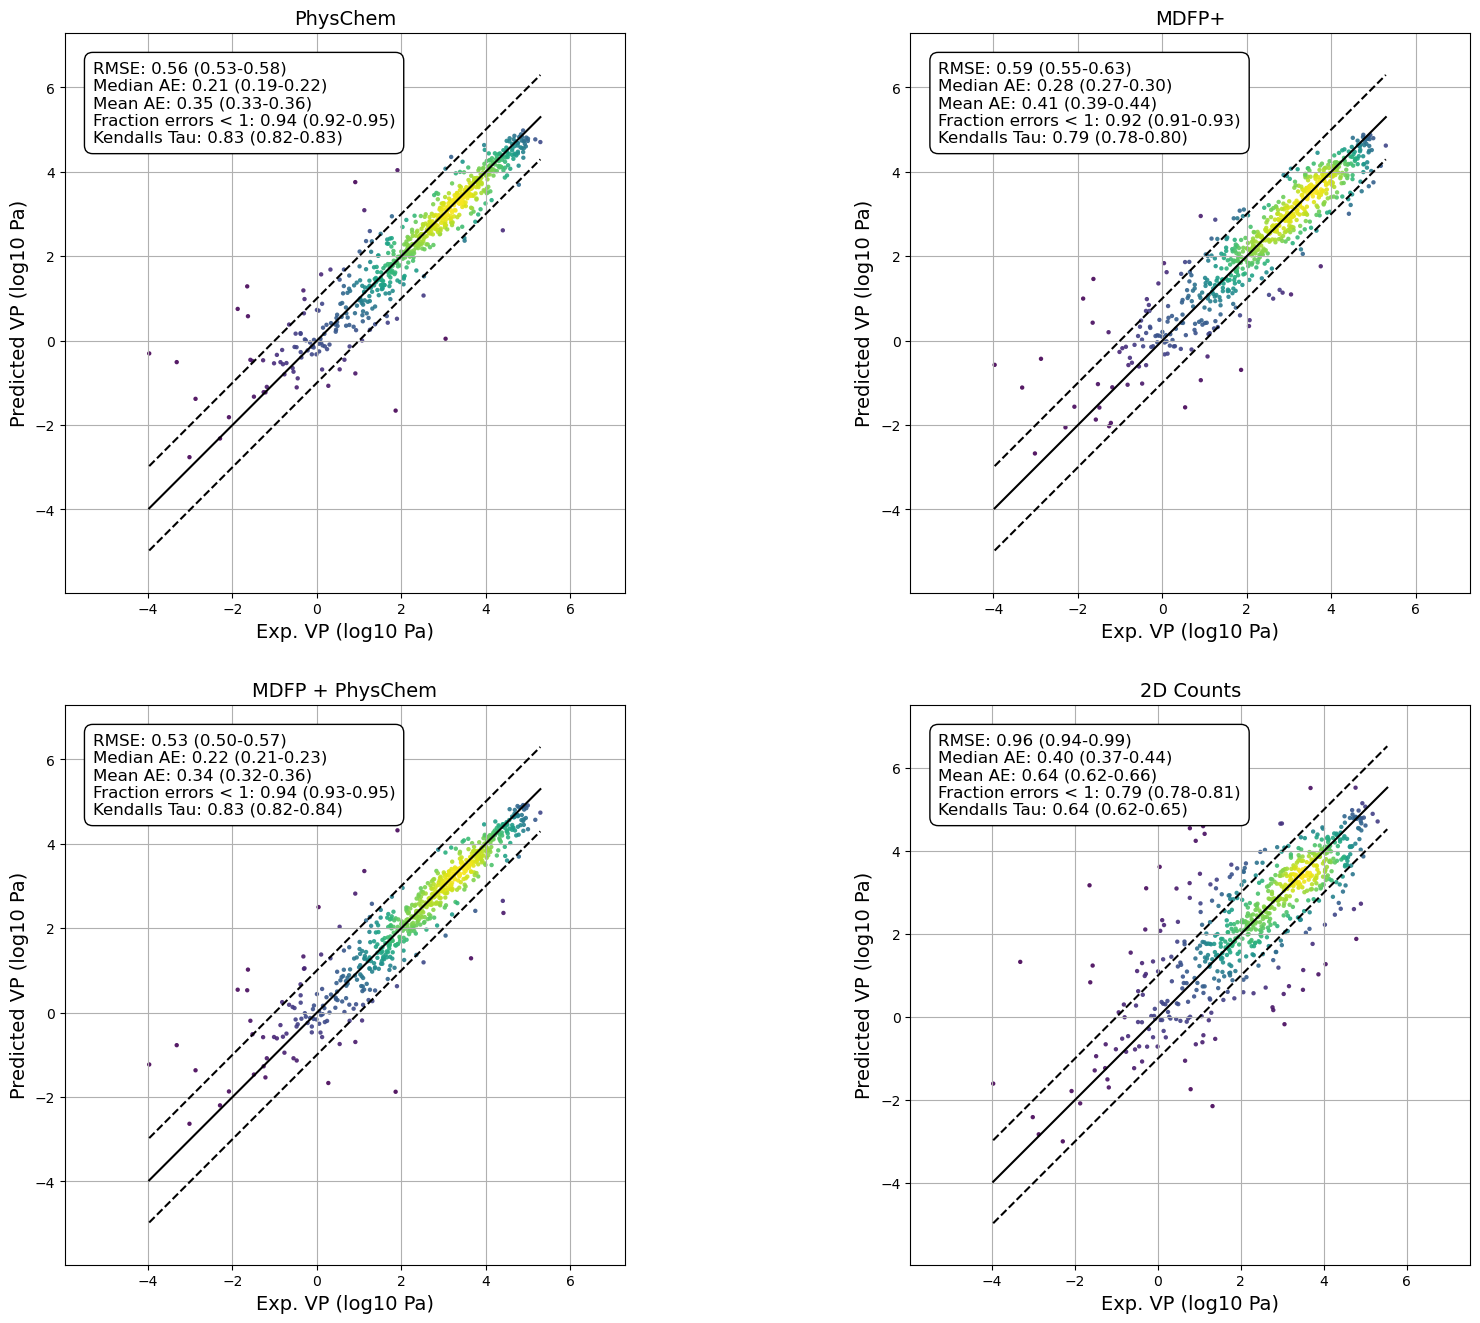

In [7]:
reals_list = [ys_list_xgboost_physchem, ys_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_counts]
predictions_list = [pred_list_xgboost_physchem, pred_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_and_physchem, pred_list_xgboost_mdfp_counts]
molregnos_list = [molregnos_xgboost_physchem, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_counts]
title = ['PhysChem', 'MDFP+', 'MDFP + PhysChem', '2D Counts']
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=title, name='XGBoost_MDFP_PhysChem_2DCounts', dims=(2,2))